In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import networkx as nx
import logging, sys
import cstrees.scoring as sc
import cstrees.cstree as ct
import causaldag
import matplotlib.pyplot as plt

#logging.basicConfig(stream=sys.stderr, level=logging.DEBUG)

# CStree from Figure 1 in (Duarte & Solus, 2022)

/home/f/l/flrios/NOBACKUP/flrios/miniconda3/envs/cstrees/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
np.random.seed(3)
p=4
cards = [2] * p
#co = ct.CausalOrder(range(p))
tree = ct.CStree(cards) # Maybe an optional label here. defaults to range(p)
#tree.set_cardinalities(cards)

# These do not have to be in a dict like this as the levels are
# determined from the length of the tuples.
tree.update_stages({
    -1: [ct.Stage([])],
    0: [],
    1: [ct.Stage([{0, 1}, 0])],    # Green
    2: [ct.Stage([0, {0, 1}, 0]),  # Blue
        ct.Stage([0, {0, 1}, 1]),  # Orange
        ct.Stage([1, {0, 1}, 0])]  # Red
})

tree.set_random_stage_parameters()
tree.create_tree()
tree.set_random_parameters()

a = tree.plot()
a.draw("testplot.png")
x = tree.sample(5)

print(x)

s = sc.score(tree, x, alpha_tot=1.0, method="K2")
print(s)
#rels = tree.csi_relations()

#print("Initial rels")
#print(rels)
adjmats = tree.to_minimal_context_graphs() # put labels here maybe

for key, graph in adjmats.items():
    agraph = nx.nx_agraph.to_agraph(graph)
    agraph.layout("dot")
    agraph.draw(str(key) + "_csi.png", args='-Glabel="'+str(key)+'"   ')
a

No stage found for (1,)


AssertionError: 

In [4]:

p=4
cards = [2] * p 

      0  1  2  3
0     2  2  2  2
1     1  0  0  1
2     1  1  1  1
3     1  0  0  1
4     1  0  0  0
...  .. .. .. ..
996   0  0  0  0
997   0  1  0  0
998   1  0  0  1
999   1  1  0  1
1000  1  1  0  1

[1001 rows x 4 columns]


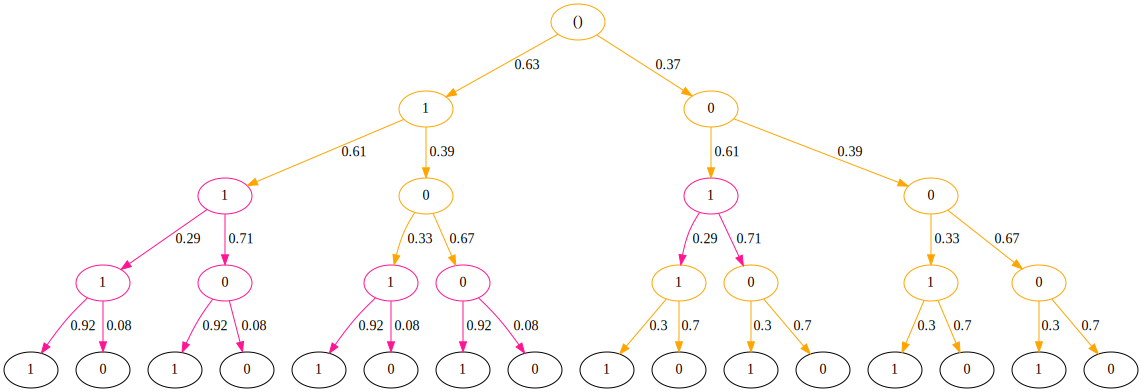

In [16]:
np.random.seed(5)

t = ct.sample_cstree(cards, max_cvars=1, prob_cvar=0.5, prop_nonsingleton=1)
t.set_random_stage_parameters()
t.create_tree()
t.set_random_parameters()
a = t.plot()
x = t.sample(1000)
print(x)
#plt.savefig("testplot.png")

true_cdags = t.to_minimal_context_graphs()
for key, val in true_cdags.items():
    agraph = nx.nx_agraph.to_agraph(val)
    agraph.layout("dot")
    agraph.draw("testing/"+str(key) + "_true.png", args='-Glabel="'+str(key)+'"   ')
a

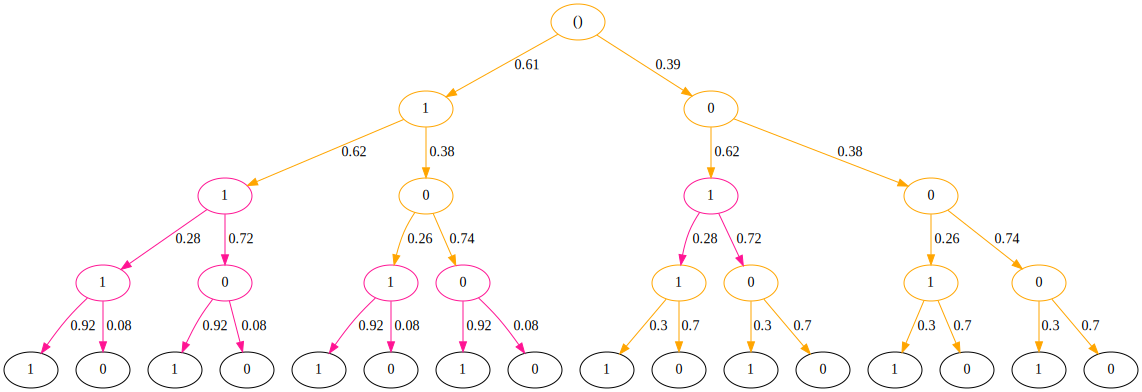

In [17]:
# Should we need to put order here? Or just the labels?
# Or nothing?
t.estimate_stage_parameters(x, alpha_tot=1.0, method="BDeu")
t.create_tree()
t.set_random_parameters()
a = t.plot()
a

In [7]:
order = [0, 1, 2, 3]

perm = [1,0,2, 3]
xperm = x[perm]

# checking that thy give the same result. MAybe thisuis better checked on a CStree
# lvelel instead of the order.

s2 = sc.score_order(perm, xperm, max_cvars=1, alpha_tot=1.0, method="BDeu")
s1 = sc.score_order(order, x, max_cvars=1, alpha_tot=1.0, method="BDeu")

print(s1)
print(s2)

-2353.4444365460217
-2353.4444365460217


order: [0, 1, 2, 3], score: -2353.4444365460217
order: [0, 1, 3, 2], score: -2353.444436546022
order: [0, 2, 1, 3], score: -2353.4444365460217
order: [0, 2, 3, 1], score: -2353.4444365460217
order: [0, 3, 1, 2], score: -2353.444436546022
order: [0, 3, 2, 1], score: -2353.444436546022
order: [1, 0, 2, 3], score: -2353.4444365460217
order: [1, 0, 3, 2], score: -2353.444436546022
order: [1, 2, 0, 3], score: -2353.4444365460217
order: [1, 2, 3, 0], score: -2353.444436546022
order: [1, 3, 0, 2], score: -2353.444436546022
order: [1, 3, 2, 0], score: -2353.444436546022
order: [2, 0, 1, 3], score: -2353.4444365460217
order: [2, 0, 3, 1], score: -2353.4444365460217
order: [2, 1, 0, 3], score: -2353.4444365460217
order: [2, 1, 3, 0], score: -2353.444436546022
order: [2, 3, 0, 1], score: -2353.444436546022
order: [2, 3, 1, 0], score: -2353.444436546022
order: [3, 0, 1, 2], score: -2353.444436546022
order: [3, 0, 2, 1], score: -2353.444436546022
order: [3, 1, 0, 2], score: -2353.444436546022
order

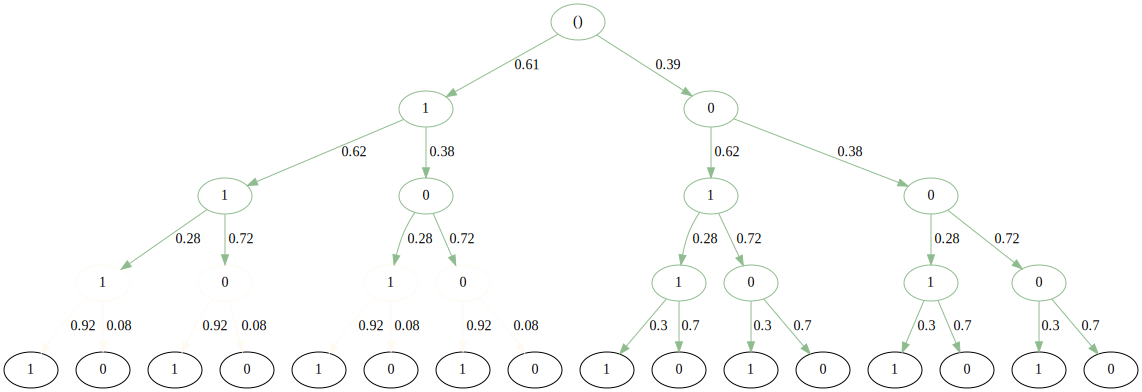

In [8]:
optord, score = ct.find_optimal_order(x, strategy="max", max_cvars=1, alpha_tot=1.0, method="BDeu")
print("optimal order: {}, score {}".format(optord, score))

opttree = ct.optimal_cstree(optord, x, max_cvars=1, alpha_tot=1.0, method="BDeu")
print("stages :{}".format(opttree.stages))
opttree.estimate_stage_parameters(x, alpha_tot=1.0, method="BDeu")
opttree.create_tree()
opttree.set_random_parameters()
opttree.plot()

In [15]:
cdags = opttree.to_minimal_context_graphs()
for key, graph in cdags.items():
    print("key: {}".format(key))
    print(graph.edges())
    print(graph.nodes())
    cdag = causaldag.DAG(arcs=set(graph.edges()))
    cpdag = cdag.cpdag()
    print(cpdag.arcs)
    print(cpdag.edges)
    print(type(cpdag))
    

key: None
[(0, 3)]
[0, 1, 2, 3]
set()
{frozenset({0, 3})}
<class 'graphical_models.classes.dags.pdag.PDAG'>


max staging: ['[]']
max staging: ['[{0, 1}]']
max staging: ['[0, {0, 1}]', '[1, {0, 1}]']
max staging: ['[0, {0, 1}, {0, 1}]', '[1, {0, 1}, {0, 1}]']
Level 0
[{0, 1}] {0: 4, 1: 1}
Level 1
[1, {0, 1}] {0: 3, 1: 1}
[0, {0, 1}] {1: 1}
Level 2
[1, {0, 1}, {0, 1}] {1: 3, 0: 1}
[0, {0, 1}, {0, 1}] {0: 1}
Level 3
Level -1
[] {1: 4, 0: 1}


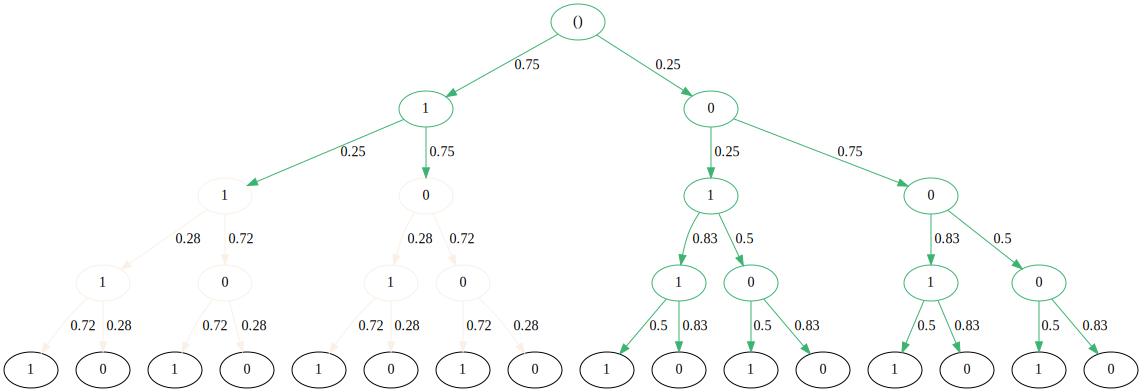

In [25]:
order = [0, 1, 2, 3]

opttree = ct.optimal_cstree(order, x, max_cvars=1, alpha_tot=1.0, method="BDeu")
#print("stages :{}".format(opttree.stages))
opttree.estimate_stage_parameters(x, alpha_tot=1.0, method="BDeu")
opttree.create_tree()
opttree.set_random_parameters()
opttree.plot()

In [44]:
optord = ct.find_optimal_order(x, max_cvars=1, alpha_tot=1.0, method="BDeu")

the labels/order/label order to read the data columns in
[0, 1, 2, 3]
data
   0  1  2  3
0  2  2  2  2
1  1  0  0  0
2  1  1  1  1
3  1  0  0  0
4  1  0  0  0
5  0  0  1  0
dfperm
   0  1  2  3
0  2  2  2  2
1  1  0  0  0
2  1  1  1  1
3  1  0  0  0
4  1  0  0  0
5  0  0  1  0
dataperm
[[1 0 0 0]
 [1 1 1 1]
 [1 0 0 0]
 [1 0 0 0]
 [0 0 1 0]]
the labels/order/label order to read the data columns in
[0, 1, 2, 3]
data
   0  1  2  3
0  2  2  2  2
1  1  0  0  0
2  1  1  1  1
3  1  0  0  0
4  1  0  0  0
5  0  0  1  0
dfperm
   0  1  2  3
0  2  2  2  2
1  1  0  0  0
2  1  1  1  1
3  1  0  0  0
4  1  0  0  0
5  0  0  1  0
dataperm
[[1 0 0 0]
 [1 1 1 1]
 [1 0 0 0]
 [1 0 0 0]
 [0 0 1 0]]
the labels/order/label order to read the data columns in
[0, 1, 2, 3]
data
   0  1  2  3
0  2  2  2  2
1  1  0  0  0
2  1  1  1  1
3  1  0  0  0
4  1  0  0  0
5  0  0  1  0
dfperm
   0  1  2  3
0  2  2  2  2
1  1  0  0  0
2  1  1  1  1
3  1  0  0  0
4  1  0  0  0
5  0  0  1  0
dataperm
[[1 0 0 0]
 [1 1 1 1]
 [1 0

In [ ]:

order = [0, 1, 2, 3]
score = sc.score_order(order, cards, x, max_cvars=1, alpha_tot=1.0, method="BDeu")
print(score)
 

In [ ]:
stagings = ct.all_stagings(order, cards, level, max_cvars=1)
print("#Stagings")
nst = ct.n_stagings(order, cards, level, max_cvars=1)
print(nst)
print("Stagings")
for ss in stagings:
    for s in ss:
        print(s)

In [ ]:
for l in range(len(order)):
    max_staging, max_score = ct.optimal_staging_at_level(order, cards, x, l, max_cvars=1, alpha_tot=1.0, method="BDeu")
    print("best staging at level {}".format(l))
    print(max_score)   
    for st in max_staging:
        print(st)

    